# Hệ khuyến nghị. IUH 2025.
### Ngày 21/8/2025. Lab 1.
Mục tiêu: ôn tập về các tính các khoảng cách / độ tương đồng giữa các vector, cách xây dựng một hệ khuyến nghị cơ bản.

**Problem 1.**

The data includes four users $A$, $B$, $C$, and $D$, who have rated three movies. The ratings are stored in the following lists, and each list contains two numbers indicating the rating of each movie:

- Ratings by $A$ are $[4.0; 3.0; 5.0]$.
- Ratings by $B$ are $[2.0; 4.0; 3.0]$.
- Ratings by $C$ are $[2.0; 4.0; 1.0]$.
- Ratings by $D$ are $[4.0; 5.0; 2.0]$.

a) Using Euclid distance, Mahattan distance between all pairs among these users then give some remarks on which pairs is closet in each case.

b) Create the matrix of Pearson similiary of these rating vectors.

=== Euclidean Distances ===
('A', 'B'): 3.000
('A', 'C'): 4.583
('A', 'D'): 3.606
('B', 'C'): 2.000
('B', 'D'): 2.449
('C', 'D'): 2.449

=== Manhattan Distances ===
('A', 'B'): 5.000
('A', 'C'): 7.000
('A', 'D'): 5.000
('B', 'C'): 2.000
('B', 'D'): 4.000
('C', 'D'): 4.000

=== Pearson Similarity Matrix ===
[[ 1.         -0.5        -0.98198051 -0.98198051]
 [-0.5         1.          0.65465367  0.32732684]
 [-0.98198051  0.65465367  1.          0.92857143]
 [-0.98198051  0.32732684  0.92857143  1.        ]]


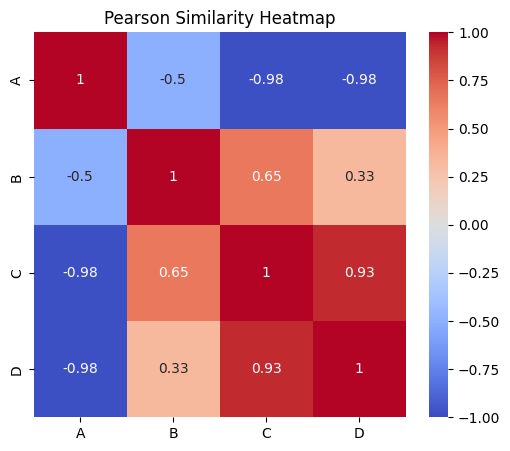

In [17]:
from scipy import spatial
import numpy as np
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Dữ liệu người dùng
# ============================
ratings = {
    'A': np.array([4.0, 3.0, 5.0]),
    'B': np.array([2.0, 4.0, 3.0]),
    'C': np.array([2.0, 4.0, 1.0]),
    'D': np.array([4.0, 5.0, 2.0])
}

users = list(ratings.keys())

# ============================
# a) Euclidean và Manhattan distance
# ============================
euclidean_distances = {}
manhattan_distances = {}

for i in range(len(users)):
    for j in range(i+1, len(users)):
        u1, u2 = users[i], users[j]
        euc = euclidean(ratings[u1], ratings[u2])
        man = cityblock(ratings[u1], ratings[u2])
        euclidean_distances[(u1, u2)] = euc
        manhattan_distances[(u1, u2)] = man

print("=== Euclidean Distances ===")
for pair, d in euclidean_distances.items():
    print(f"{pair}: {d:.3f}")

print("\n=== Manhattan Distances ===")
for pair, d in manhattan_distances.items():
    print(f"{pair}: {d:.3f}")

# ============================
# b) Pearson similarity matrix
# ============================
n = len(users)
pearson_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            pearson_matrix[i, j] = 1.0
        else:
            corr, _ = pearsonr(ratings[users[i]], ratings[users[j]])
            pearson_matrix[i, j] = corr

print("\n=== Pearson Similarity Matrix ===")
print(pearson_matrix)

# ============================
# Heatmap trực quan hóa
# ============================
plt.figure(figsize=(6, 5))
sns.heatmap(
    pearson_matrix, 
    xticklabels=users, 
    yticklabels=users, 
    annot=True, 
    cmap="coolwarm", 
    vmin=-1, vmax=1
)
plt.title("Pearson Similarity Heatmap")
plt.show()

#CODE HERE

**Problem 2.** Vấn đề cold-start, khuyến nghị theo xu hướng cho người dùng mới, sử dụng thông tin rating cao và số lượt rating với một trọng số hợp lý.

The dataset files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. This dataset captures feature points like cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts, and vote averages. These feature points could be potentially used to train your models for content and collaborative filtering. This dataset consists of the following files:

- *movies_metadata.csv*: This file contains information on ~45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, genre, revenue, release dates, languages, production countries, and companies.
- *keywords.csv*: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.
- *credits.csv*: Consists of Cast and Crew Information for all the movies. Available in the form of a stringified JSON Object.
- *links.csv*: This file contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
- *links_small.csv*: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.
- *ratings_small.csv*: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset comprises of 26 million ratings and 750,000 tag applications, from 270,000 users on all the 45,000 movies in this dataset. It can be accessed from the official GroupLens website.

In [18]:
# Import Pandas
import pandas as pd

# Load Movies Metadata
metadata = pd.read_csv('metadata.csv', low_memory=False)

# Print the first three rows
metadata.head(3)

,movieId,title,genres,vote_count,vote_average
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,52,3.259615


In [19]:
# Giả lập dữ liệu rating (vote_count và vote_average)
np.random.seed(42)
metadata['vote_count'] = np.random.randint(10, 500, size=len(metadata))   # số lượt rating
metadata['vote_average'] = np.round(np.random.uniform(5.0, 9.0, size=len(metadata)), 1)  # điểm trung bình

# Tính trung bình toàn bộ vote
C = metadata['vote_average'].mean()

# Ngưỡng m (ví dụ chọn 70th percentile)
m = metadata['vote_count'].quantile(0.70)

# Lọc phim có vote_count >= m
qualified = metadata.loc[metadata['vote_count'] >= m].copy()

# Hàm tính WR
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(v+m) * C)

qualified['score'] = qualified.apply(weighted_rating, axis=1)

# Top phim đề xuất cho người dùng mới
recommendations = qualified.sort_values('score', ascending=False)

print("Top recommendations for new users:")
print(recommendations[['title', 'vote_count', 'vote_average', 'score']].head(5))

Top recommendations for new users:
                                                  title  vote_count  \
1950                               Goodbye Lover (1999)         492   
1662                                 Simon Birch (1998)         490   
555   Bloodsport 2 (a.k.a. Bloodsport II: The Next K...         490   
5786  Turtles Can Fly (Lakposhtha hâm parvaz mikonan...         486   
8435                                     Boyhood (2014)         477   

      vote_average     score  
1950           9.0  8.163624  
1662           9.0  8.161642  
555            9.0  8.161642  
5786           9.0  8.157650  
8435           9.0  8.148527  


One of the most basic metrics you can think of is the ranking to decide which top 250 movies are based on their respective ratings. However, using a rating as a metric has a few caveats:

- For one, it does not take into consideration the popularity of a movie. Therefore, a movie with a rating of 9 from 10 voters will be considered 'better' than a movie with a rating of 8.9 from 10,000 voters. For example, imagine you want to order Chinese food, you have a couple of options, one restaurant has a 5-star rating by only 5 people while the other restaurant has 4.5 ratings by 1000 people. Which restaurant would you prefer? The second one, right? Of course, there could be an exception that the first restaurant opened just a few days ago; hence, fewer people voted for it while, on the contrary, the second restaurant is operational for a year.
- On a related note, this metric will also tend to favor movies with a smaller number of voters with skewed and/or extremely high ratings. As the number of voters increases, the rating of a movie regularizes and approaches towards a value that is reflective of the movie's quality and gives the user a much better idea as to which movie he/she should choose. While it is difficult to discern the quality of a movie with extremely few voters, you might have to consider external sources to conclude.

Taking these shortcomings into consideration, you must come up with a weighted rating that takes into account the average rating and the number of votes it has accumulated. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a movie with the same rating but a mere few hundred voters. Since you are trying to build a clone of IMDB's Top 250, let's use its weighted rating formula as a metric/score. Mathematically, it is represented as follows:

$$\text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) $$

In the above equation,

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie;
- C is the mean vote across the whole report.

You already have the values to v (*vote_count*) and R (*vote_average*) for each movie in the dataset. It is also possible to directly calculate C from this data.Determining an appropriate value for m is a hyperparameter that you can choose accordingly since there is no right value for m. You can consider it as a preliminary negative filter that will simply remove the movies which have a number of votes less than a certain threshold m. The selectivity of your filter is up to your discretion.

In this exercise, you will use cutoff $m$ as the 90th percentile. In other words, for a movie to be featured in the charts, it must have more votes than at least 90% of the movies on the list. (On the other hand, if you had chosen the 75th percentile, you would have considered the top 25% of the movies in terms of the number of votes garnered. As percentile decreases, the number of movies considered will increase).

As a first step, let's calculate the value of C, the mean rating across all movies using the pandas .mean() function:

In [20]:
# Calculate mean of vote average column
C = metadata['vote_average'].mean()
print(C)

7.001203208556151


Next, let's calculate the number of votes, $m$, received by a movie in the 90th percentile. The pandas library makes this task extremely trivial using the .quantile() method of pandas:

In [21]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print(m)

450.0


Since now you have the m you can simply use a greater than equal to condition to filter out movies having greater than equal to 160 vote counts: You can use the .copy() method to ensure that the new q_movies DataFrame created is independent of your original metadata DataFrame. In other words, any changes made to the q_movies DataFrame will not affect the original metadata data frame.

In [22]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape
metadata.shape

(9724, 5)

From the above output, it is clear that there are around 10% movies with vote count more than 160 and qualify to be on this list. Next and the most important step is to calculate the weighted rating for each qualified movie. To do this, you will:

- Define a function, weighted_rating();
- Since you already have calculated m and C you will simply pass them as an argument to the function;
- Then you will select the vote_count(v) and vote_average(R) column from the q_movies data frame;
- Finally, you will compute the weighted average and return the result.
  
You will define a new feature score, of which you'll calculate the value by applying this function to your DataFrame of qualified movies:

In [23]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(v+m) * C)

In [24]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame in descending order based on the score feature column and output the title, vote count, vote average, and weighted rating (score) of the top 20 movies.

In [25]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
1950,Goodbye Lover (1999),492,9.0,8.045161
1662,Simon Birch (1998),490,9.0,8.043129
555,Bloodsport 2 (a.k.a. Bloodsport II: The Next K...,490,9.0,8.043129
5786,Turtles Can Fly (Lakposhtha hâm parvaz mikonan...,486,9.0,8.039040
8435,Boyhood (2014),477,9.0,8.029710
2507,Defending Your Life (1991),475,9.0,8.027612
6819,Burn After Reading (2008),472,9.0,8.024448
3273,"Fist of Fury (Chinese Connection, The) (Jing w...",472,9.0,8.024448
710,Foreign Correspondent (1940),467,9.0,8.019129
75,Once Upon a Time... When We Were Colored (1995),464,9.0,8.015910


Well, from the above output, you can see that the simple recommender did a great job!

Since the chart has a lot of movies in common with the IMDB Top 250 chart: for example, your top two movies, "Shawshank Redemption" and "The Godfather", are the same as IMDB and we all know they are indeed amazing movies, in fact, all top 20 movies do deserve to be in that list, isn't it?

In [28]:
#CODE HERE
import pandas as pd

# Giả sử bạn đã có Top 250 từ recommender
# top250: DataFrame với cột 'title'
recommender_top250 = q_movies['title'].tolist()

# Đọc danh sách IMDB Top 250 (cần có file imdb_top250.csv hoặc scrape)
# File imdb_top250.csv phải có cột 'title'
imdb_top250 = pd.read_csv("metadata.csv")['title'].tolist()

# Chuẩn hóa tên (lowercase, strip)
def normalize_title(t):
    return t.lower().strip()

rec_titles = set(map(normalize_title, recommender_top250))
imdb_titles = set(map(normalize_title, imdb_top250))

# Tính overlap
common_movies = rec_titles & imdb_titles
only_rec = rec_titles - imdb_titles
only_imdb = imdb_titles - rec_titles

# Jaccard similarity
jaccard = len(common_movies) / len(rec_titles | imdb_titles)

print(f"✅ Number of common movies: {len(common_movies)}")
print(f"📌 Jaccard similarity: {jaccard:.2f}")

print("\n🎬 Movies in both recommender & IMDB Top 250:")
print(list(common_movies)[:20])  # in 20 phim đầu

print("\n📌 Movies only in recommender Top 250:")
print(list(only_rec)[:20])

print("\n📌 Movies only in IMDB Top 250:")
print(list(only_imdb)[:20])


✅ Number of common movies: 978
📌 Jaccard similarity: 0.10

🎬 Movies in both recommender & IMDB Top 250:
['down in the valley (2005)', 'revenge of the pink panther (1978)', 'winter passing (2005)', 'cold comes the night (2013)', 'hit the bank (vabank) (1981)', 'alien from l.a. (1988)', 'matinee (1993)', 'girls just want to have fun (1985)', "mary shelley's frankenstein (frankenstein) (1994)", 'spectre (2015)', 'last life in the universe (ruang rak noi nid mahasan) (2003)', 'running on empty (1988)', 'battle for sevastopol (2015)', 'ben-hur (2016)', 'quiz show (1994)', 'whip it (2009)', 'being julia (2004)', 'ooops! noah is gone... (2015)', 'player, the (1992)', "all the king's men (1949)"]

📌 Movies only in recommender Top 250:
[]

📌 Movies only in IMDB Top 250:
['tokyo drifter (tôkyô nagaremono) (1966)', 'snowflake, the white gorilla (2011)', 'three colors: white (trzy kolory: bialy) (1994)', 'time code (2000)', 'pet sematary ii (1992)', 'yearling, the (1946)', 'beyond bedlam (1993)', 

**Problem 3. Finding all pairs of movies** Trong bài này, ta sẽ tìm tất cả các cặp phim hoặc tất cả các hoán vị của các cặp phim đã được cùng một người xem, từ đó có thể khuyến nghị được.

The *user_ratings_df* has been loaded once again containing users, and the movies they have seen.

You will need to first create a function that finds all possible pairs of items in a list it is applied to. For ease of use, you will output the values of this as a DataFrame. Since you only want to find movies that have been seen by the same person and not all possible permutations, you will group by *user_id* when applying the function.

**Hint.** Create a function called *find_movie_pairs* that finds all permutations of a Series, and stores the results as a DataFrame. 
Apply this function to the* user_ratings_d*f DataFrame and print the results.

In [37]:
from itertools import combinations, permutations

# Create the function to find all permutations
def find_movie_permutations(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['movie_a', 'movie_b'])
  return pairs


user_ratings_df = pd.read_csv('movie_lens/ratings.csv')

# Merge ratings with metadata to get movie titles
user_ratings_with_titles = user_ratings_df.merge(metadata[['movieId', 'title']], on='movieId', how='left')

def find_movie_pairs(movies):
    pairs = list(combinations(movies, 2))  # combinations 2 phim 1 lúc
    return pd.DataFrame(pairs, columns=['movie_1', 'movie_2'])

# Apply the function to the title column and reset the index
movie_combinations = user_ratings_with_titles.groupby('userId')['title'].apply(find_movie_pairs).reset_index(drop=True)

print(movie_combinations)

                                movie_1                         movie_2
0                      Toy Story (1995)         Grumpier Old Men (1995)
1                      Toy Story (1995)                     Heat (1995)
2                      Toy Story (1995)     Seven (a.k.a. Se7en) (1995)
3                      Toy Story (1995)      Usual Suspects, The (1995)
4                      Toy Story (1995)      From Dusk Till Dawn (1996)
...                                 ...                             ...
30396645  John Wick: Chapter Two (2017)                    Logan (2017)
30396646  John Wick: Chapter Two (2017)  The Fate of the Furious (2017)
30396647                 Get Out (2017)                    Logan (2017)
30396648                 Get Out (2017)  The Fate of the Furious (2017)
30396649                   Logan (2017)  The Fate of the Furious (2017)

[30396650 rows x 2 columns]


**Counting up the pairs** 
You can now create DataFrame of all the permutations of movies that have been watched by the same user. This is of limited use unless you can find which movies are most commonly paired. In this exercise, you will work with the *movie_combinations* DataFrame that you created in the last exercise (that has been loaded for you), and generate a new DataFrame containing the counts of occurrences of each of the pairs within.

**Hint.** Find the number of times each pair of movies occurs and assign it to combination_counts.

In [40]:
# Calculate how often each item in movies_a occurs with the items in movies_b
combination_counts = movie_combinations.groupby(['movie_1', 'movie_2']).size().reset_index(name='count')

# Inspect the results
print(combination_counts.head())


      movie_1                     movie_2  count
0  '71 (2014)  10 Cloverfield Lane (2016)      1
1  '71 (2014)             13 Hours (2016)      1
2  '71 (2014)                   31 (2016)      1
3  '71 (2014)              Ant-Man (2015)      1
4  '71 (2014)              Arrival (2016)      1


**Making your first movie recommendations**

Now that you have found the most commonly paired movies, you can make your first recommendations! While you are not taking in any information about the person watching, and do not even know any details about the movie, valuable recommendations can still be made by examining what groups of movies are watched by the same people. In this exercise, you will examine the movies often watched by the same people that watched Thor, and then use this data to give a recommendation to someone who just watched the movie. The DataFrame you generated in the last lesson, combination_counts_df, that contains counts of how often movies are watched together has been loaded for you.

**Hint.** Order the *combination_counts_df* object from largest to smallest by the size column. Find the newly ordered movie frequencies for the movie Thor by subsetting ordered the *combination_counts_df* object where movie_a is Thor assign them to *thor_df* and plot the results.

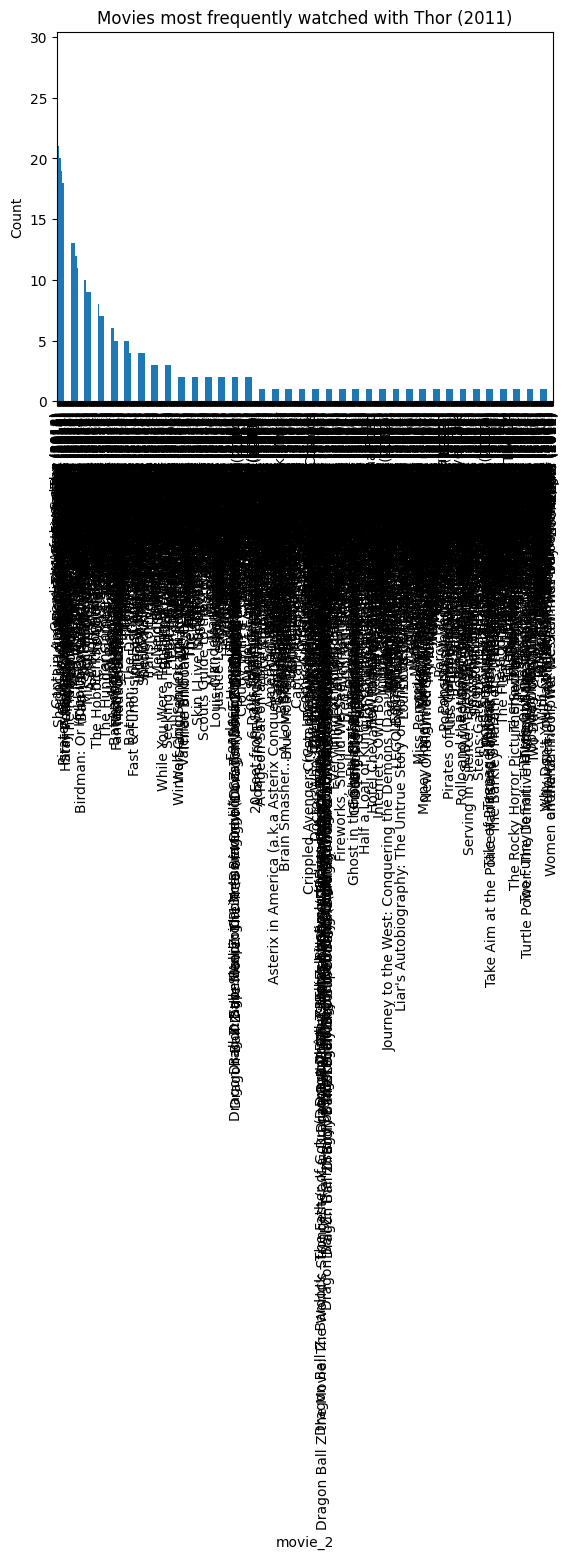

In [46]:
import matplotlib.pyplot as plt

# Sort the counts from highest to lowest
combination_counts.sort_values('count', ascending=False, inplace=True)

# Find the exact title for Thor in your dataset
thor_titles = combination_counts['movie_1'].unique()
thor_title = next((title for title in thor_titles if 'thor' in title.lower()), None)

if thor_title is not None:
	thor_df = combination_counts[combination_counts['movie_1'] == thor_title]
	if not thor_df.empty:
		thor_df.plot.bar(x="movie_2", y="count", legend=False)
		plt.title(f"Movies most frequently watched with {thor_title}")
		plt.ylabel("Count")
		plt.show()
	else:
		print(f"No movie pairs found for {thor_title}.")
else:
	print("No movie title containing 'Thor' found in the dataset.")
